# HABSlib 104
In this fourth notebook, we will learn how to assess the quality of the BrainOS APIs for feature extraction.

### What is Quality Assessment
Quality assessment is the data collection and analysis process, which measures the degree of conformity to predetermined standards and criteria ([NIH Medicare](https://www.ncbi.nlm.nih.gov/books/NBK235459/)).

### How we do it
For this session, we will use the HABSlib EEG simulator to have an EEG signal of known frequency content and noise. Then we will use the BrainOS API to analyze such content.      
In particular, we will compare two EEG simulations to measure how noise affects the BrainOS ability to extract a known amplitude alpha content.
    
Please, refer to the documentation of [HABSlib](https://olocufier.github.io/HABSlib/) for further details.

In [27]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb
from datetime import datetime
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


## Login
As usual, the first thing to do to start a session with the HABS BrainOS is to handshake.

In [44]:
# hb.handshake(base_url="http://135.237.144.125/", user_id='8d60e8693a9560ee57e8eba3') # staging
hb.handshake(base_url="http://74.249.61.11/", user_id='8d60e8693a9560ee57e8eba3') # testing
# hb.handshake(base_url="http://0.0.0.0/", user_id='8d60e8693a9560ee57e8eba3') # development


       HUMAN        AUGMENTED        BRAIN         SYSTEMS    
   ---------------------------------------------------------- 
   ▒▒▒▒     ▒▒▒▒     ░▒▒▒▒▒░     ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░  
   ▒▒▒▒     ▒▒▒▒    ░▒▒▒▒▒▒▒░             ░▒▒▒▒ ░▒▒▒░     ░▒░ 
   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒ ▒▒▒▒░   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒▒▒▒▒▒░  
   ▒▒▒▒     ▒▒▒▒  ░▒▒▒▒   ▒▒▒▒░  ▒▒▒▒     ░▒▒▒▒ ░▒░     ░▒▒▒░ 
   ▒▒▒▒     ▒▒▒▒ ░▒▒▒▒     ▒▒▒▒░ ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░  
   ---------------------------------------------------------- 
   version: 0.1.48

Handshake (RSA) successful.
Handshake (AES) successful.


True

## Synthetic data with no noise
First, we look at the simulated EEG with no added noise and a high beta content.

In [45]:
# Acquire synthetic EEG data with the current noise and beta amplitude
session_no_noise_id = hb.acquire_send_raw(
    user_id='8d60e8693a9560ee57e8eba3', 
    date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'), 
    board="SYNTHETIC", 
    extra={
        "eeg_channels": 16,
        "sampling_rate": 250,
        "noise": 0,           # noise amplitude, microvolts (µV)
        "artifacts": 0.0,     # probability of having a movement/blink artifact in the recording
        "beta_amp": 15,       # beta amplitude, microvolts (µV)
        "modulation_type": 'random',
        "power_law_slope": 1.0
    },
    serial_number="", 
    stream_duration=20, 
    buffer_duration=5
)

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66c8ea939d04fcc0979a7505 

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-23 22:01:22', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...


In [46]:
# Retrieve the data for the session
print(session_no_noise_id)
results_zero = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id=session_no_noise_id)
eeg_data_zero = np.array(results_zero)
print(np.mean(eeg_data_zero))

66c8ea939d04fcc0979a7505
Retrieved data successfully.
11.972852224322667


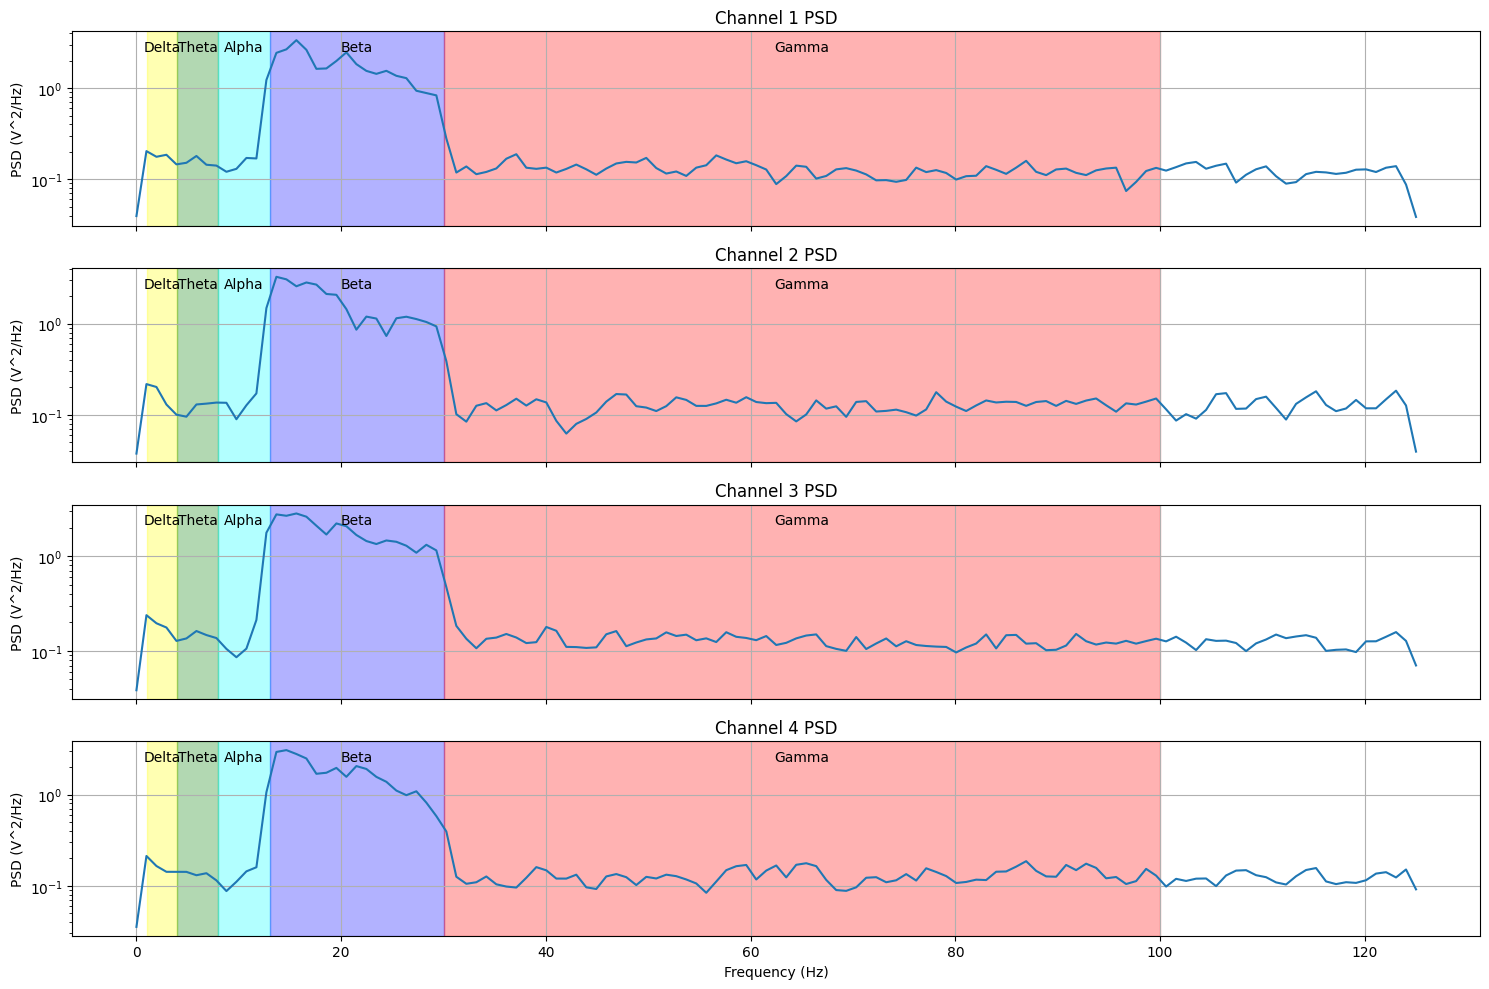

In [47]:
from scipy import signal

samples_per_second = 250
num_channels=4 # how many you want to plot

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(eeg_data_zero[i], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)

    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## Synthetic data with noise
Then, we look at the simulated EEG with high Beta content and high noise too.

In [6]:
extra_noise = {
    "eeg_channels": 16,
    "sampling_rate": 250,
    "noise": 10,           # noise amplitude, microvolts (µV)
    "beta_amp": 15,         # beta amplitude, microvolts (µV)
    "artifacts": 0.0,
    "modulation_type": 'random',
    "power_law_slope": 1.0
}

# Acquire synthetic EEG data with the current noise and beta amplitude
session_noise_id = hb.acquire_send_raw(
    user_id='8d60e8693a9560ee57e8eba3', 
    date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'), 
    board="SYNTHETIC", 
    extra=extra_noise,
    serial_number="", 
    stream_duration=20, 
    buffer_duration=5
)

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66c85864c2d097d3e148796b 

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-23 11:37:40', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...


In [7]:
# Retrieve the data for the session
print(session_noise_id)
results_noise = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id=session_noise_id)
eeg_data_noise = np.array(results_noise)
print(np.mean(eeg_data_noise))

66c85864c2d097d3e148796b
Retrieved data successfully.
11.948544017723272


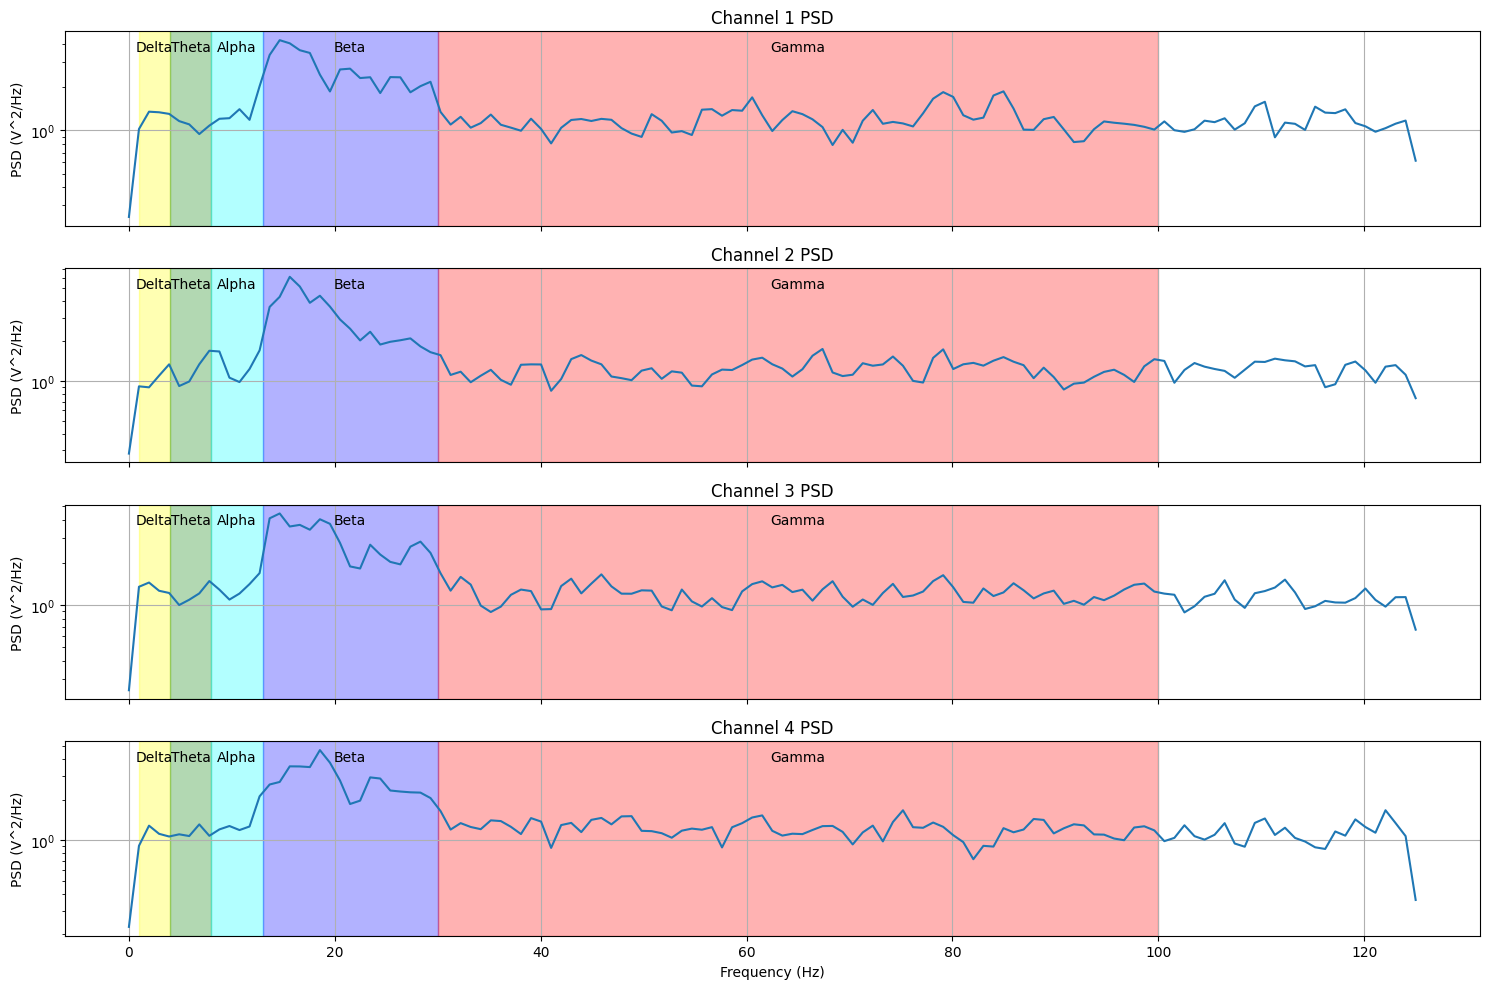

In [8]:
samples_per_second = 250
num_channels=4 # how many you want to plot

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig2, axes2 = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd2 = signal.welch(eeg_data_noise[i], fs=samples_per_second)
    axes2[i].semilogy(freqs, psd2)
    axes2[i].set_title(f'Channel {i+1} PSD')
    axes2[i].set_ylabel('PSD (V^2/Hz)')
    axes2[i].grid(True)
    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes2[i].axvspan(low, high, color=col, alpha=0.3)
        axes2[i].text((low + high) / 2, max(psd2), band, horizontalalignment='center', verticalalignment='top')

axes2[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## Quality Assessment Strategy
We will generate different dummy EEG signals with known content, to be able to compare the analysis capabilities of the BrainOS API.

We will compare the results of the example API pipeline `/filtering/<band>` for different values of signal (the amplitude of <band> we provide) and noise (also amplitudes we provide).

We automatize this strategy to know exactly which level of band amplitude we can reliably extract with which noise amplitude. In particular, we will change iteratively:
- the noise amplitude (between 0 and 10)
- the beta amplitude (between 5 and 15)

We then measure the ratio between the beta power extracted by the BrainOS API and that estimated without noise (Signal to Signal Ratio, SSR).     

#### Signal estimation
For a pure sinusoidal signal of the form:
$$signal(t) = A * sin(2\pi * f)$$
where A is the amplitude, f is the frequency. And the power of the signal is given by:
$$P = {A^2 \over 2}$$

However, to accurately estimate the power of the generated EEG signal based on the `beta_amp` parameter, we need to take into account how the signal generation process distributes power across multiple channels, frequencies, and the modulation applied.      
We can modify the calculation by considering the following factors:
- Number of Frequencies in the Beta Band: The beta_amp is distributed across multiple frequencies within the beta band (13-30 Hz). The EEG signal generation function uses multiple sinusoids to represent this band, the power from each sinusoid contributes to the total beta power.
- Power Law Distribution: a power law is applied, therefore lower frequencies have more power than higher ones, leading to an uneven distribution.
- Modulation Effects: a modulation is used (sinusoidal or random) that varies the effective amplitude over time, largely reducing the average power.
- Noise: Noise adds extra variance to the signal, reducing the proportion of power attributable to the intended beta amplitude.

A more refined expression to compute the power is as follows:
$$P_{expected} = {A^2 \over 2} * {1 \over N}\Sigma^{N}_{i=1}p_i * m_i * {1 \over 1+{\sigma_{noise}}}$$

where A is the amplitude, N is the number of frequencies within the beta band, p is the power law factor for each frequency, m is the modulation factor for each frequency, and $\sigma_{noise}$ is the noise variance (assuming a gaussian distribution).

In [65]:
# Step 1: Define the grid search parameters
noise_levels = np.arange(0, 10, 3)   # Noise amplitude, microvolts (µV)
beta_levels = np.arange(5, 15, 3)    # Beta amplitude, microvolts (µV)
print(f"{len(noise_levels)}x{len(beta_levels)} combinations = {len(noise_levels)*len(beta_levels)}")

ssr_results = np.zeros((len(noise_levels), len(beta_levels)))

# Step 2: Grid search to generate synthetic EEG and calculate SSR
for i, noise_amp in enumerate(noise_levels):
    for j, beta_amp in enumerate(beta_levels):
        print(f"\n\n---------------------------\nTest {i},{j} = noise:{noise_amp} beta:{beta_amp}\n")
        
        # Step 1: Estimate the actual power of the beta band
        # beta_power_actual = (beta_amp ** 2) / 2 # 
        freqs = np.linspace(13, 30, 10)  # 10 frequencies in the beta band, as in the simulator
        power_law_slope = 1.0 # as above
        modulation_factor = 0.15  # average modulation factor
        power_weights = (freqs / min(freqs)) ** -power_law_slope
        # noise power (variance)
        noise_power = noise_amp ** 2
        signal_power = (beta_amp ** 2 / 2) * np.mean(power_weights) * modulation_factor
        # expected power
        # beta_power_actual = signal_power / (1 + noise_power / signal_power)
        beta_power_actual = signal_power / (1+noise_power)
        print("Computed Beta power: ",beta_power_actual)
        
        # Step 2: Acquire synthetic EEG data with the current noise and beta amplitude
        session_id = hb.acquire_send_raw(
            user_id='8d60e8693a9560ee57e8eba3', 
            date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'), 
            board="SYNTHETIC", 
            extra={
                "eeg_channels": 16,
                "sampling_rate": 250,
                "noise": noise_amp,            # noise amplitude, microvolts (µV)
                "beta_amp": beta_amp,          # beta amplitude, microvolts (µV)
                "artifacts": 0.0,              # probability of having a movement/blink artifact in the recording
                "power_law_slope": 1.0
            },
            serial_number="", 
            stream_duration=20, 
            buffer_duration=5
        )
        
        # Step 3: API call to compute beta band power
        # parameters for the filtering
        b_notch, a_notch = signal.iirnotch(50., 2.0, 250)
        sos = signal.butter(10, [1, 40], 'bandpass', fs=250, output='sos')
        new_session_id, processed_data = hb.process_session_pipe(
            pipeline='/filtering/artifact/beta',
            params={ 
                "filtering": {'a_notch': a_notch.tolist(), 'b_notch': b_notch.tolist(), 'sos': sos.tolist(),},
                "artifact":{},
                "beta":{},
            },
            user_id='8d60e8693a9560ee57e8eba3', 
            existing_session_id = session_id,
            date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'),
            session_type="Quality Assessment Feature Extraction", 
            tags=['beta']
        )
        extracted_beta = np.array(processed_data)
        
        # Step 4: Get the extracted beta power from API
        beta_power_extracted = np.max(extracted_beta)  
        print("Measured Beta power (from BrainOS): ", beta_power_extracted)

        # Step 5: Compute SSR
        ssr = 10 * np.log10(beta_power_extracted / beta_power_actual) # SSR in dB
        
        # store the SSR result
        ssr_results[i, j] = np.mean(ssr)

4x4 combinations = 16


---------------------------
Test 0,0 = noise:0 beta:5

Computed Beta power:  1.215343294410556
Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66c8fae29d04fcc0979a7739 

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-23 23:10:58', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...
{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-23 23:11:24', 'existing_session_id': '66c8fae29d04fcc0979a7739', 'session_type': '[On 66c8fae29d04fcc0979a7739]: Quality Assessment Feature Extraction', 'session_tags': ['beta']}
Metadata validation successful!
Session successfully created.
Measured Beta power (from BrainOS):  1.1634982531410292


---------------------------
Test 0,1 = noise:0 beta:8

Computed Beta power:  3.1112788336910238
Session suc

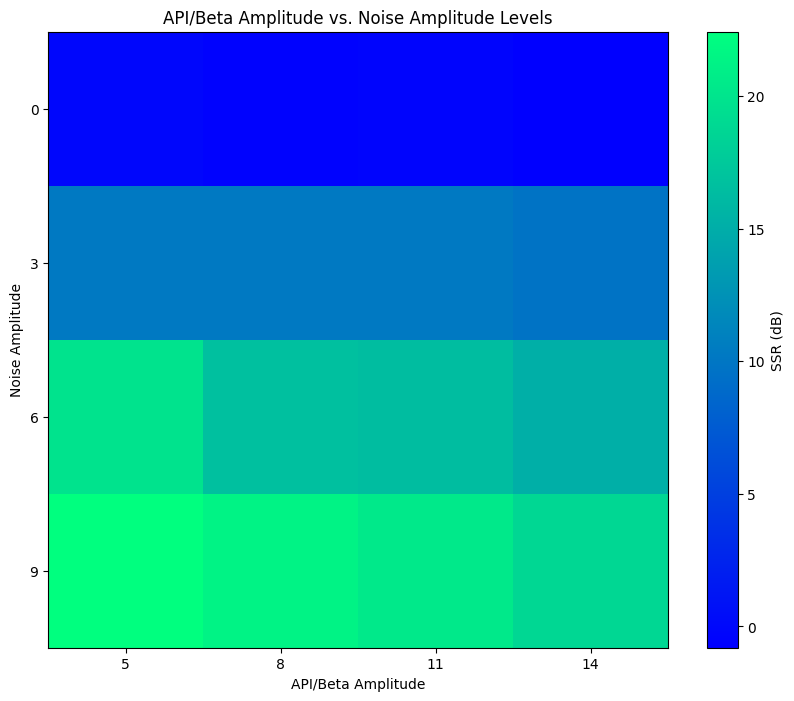

In [66]:
# Step 6: Visualize the results with a heatmap
plt.figure(figsize=(10, 8))
# plt.imshow(ssr_results, cmap="YlGnBu", aspect='auto')
# plt.imshow(ssr_results, cmap="PRGn", aspect='auto')
plt.imshow(ssr_results, cmap="winter", aspect='auto')
plt.colorbar(label='SSR (dB)')
plt.xticks(ticks=np.arange(0,len(beta_levels)), labels=beta_levels)
plt.yticks(ticks=np.arange(len(noise_levels)), labels=noise_levels)
plt.title("API/Beta Amplitude vs. Noise Amplitude Levels")
plt.xlabel("API/Beta Amplitude")
plt.ylabel("Noise Amplitude")
plt.show()

## Evaluation

At 0 noise amplitude, the BrainOS API extraction and the expected content of beta power are equivalent, and their ratio close to one, therefore 0 on the dB (log) scale. 

Now we have a reproducible measure of the range of noise and signal values within which the API is capable of extracting the beta content.

# Next steps
**Different Noise Types**: Instead of just increasing noise amplitude linearly, introduce different types of noise (e.g., white noise, pink noise, bursts of noise) and evaluate how these impact feature extraction.

**Multiple Runs per Condition**: For each combination of noise and feature amplitude, run multiple simulations to account for the stochastic nature of EEG generation and noise. Compute the average and standard deviation of the extracted feature content to get a more reliable assessment.

**Multi-Feature Analysis**: It would be valuable to simultaneously assess other extracted features (e.g., power in other bands, entropy) to see how noise affects the overall feature set.

**Benchmark Against Real Data**: Compare synthetic data with real EEG data under similar noise conditions. This would help ensure that the synthetic data accurately represents real-world scenarios.

**Time-Based Variation**: Instead of just looking at static EEG segments, analyze how the extraction performs over time if noise levels or alpha content change dynamically within the signal.